In [1]:
import argparse
import os
import sys
import torch
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import exifread
import math
from PIL import Image
from PIL.ExifTags import TAGS
import xml.etree.ElementTree as ET

import pytorch3d

from IPython.core import ultratb
sys.excepthook = ultratb.FormattedTB(call_pdb=True)

from IPython.core.debugger import set_trace # debug


# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

from pytorch3d.renderer.mesh.shader import SoftDepthShader, HardDepthShader
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PerspectiveCameras,
    PointLights, 
    DirectionalLights, 
    AmbientLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRendererWithFragments, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex,
    TexturesAtlas,
)


# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:7")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [86]:
def torch_depth_to_colormap_np(depth):
    depth_normalized = torch.zeros(depth.shape, device=device)

    valid_mask = depth > -0.9 # valid
    if valid_mask.sum() > 0:
        d_valid = depth[valid_mask]
        depth_normalized[valid_mask] = (d_valid - d_valid.min()) / (d_valid.max() - d_valid.min())

        depth_np = (depth_normalized.cpu().numpy()[0] * 255).astype(np.uint8)
        depth_color = cv2.applyColorMap(depth_np, cv2.COLORMAP_JET)
        depth_normalized = depth_normalized.cpu().numpy()[0] * 255
    else:
        print('!!!! No depth projected !!!')
        depth_color = depth_normalized = np.zeros(depth.shape, dtype=np.uint8)
    return depth_color, depth_normalized

def np_depth_to_colormap(depth, normalize=True, thres=-1):
    """ depth: [H, W] """
    depth_normalized = np.zeros(depth.shape)

    valid_mask = depth > -0.9 # depth for invalid pixel is -1
    if valid_mask.sum() > 0:
        d_valid = depth[valid_mask]

        if normalize:
            depth_normalized[valid_mask] = (d_valid - d_valid.min()) / (d_valid.max() - d_valid.min())
        elif thres > 0:
            depth_normalized[valid_mask] = d_valid.clip(0, thres) / thres
        else:
            depth_normalized[valid_mask] = d_valid

        depth_np = (depth_normalized * 255).astype(np.uint8)
        depth_color = cv2.applyColorMap(depth_np, cv2.COLORMAP_JET)
        depth_normalized = depth_normalized
    else:
        print('!!!! No depth projected !!!')
        depth_color = depth_normalized = np.zeros(depth.shape, dtype=np.uint8)
    return depth_color, depth_normalized

def load_mesh(obj_filename, nerf_metadata=None, save_mesh=False):
    """docstring for load_mesh"""

    # Load obj file
    #mesh = load_objs_as_meshes([obj_filename], device=device)
    verts, faces, aux = load_obj(obj_filename, device=device,
                                load_textures=True,
                                create_texture_atlas=True,
                                texture_atlas_size=8,
                                texture_wrap=None,
                                )

    print('loaded obj')
    atlas = aux.texture_atlas
    
    print('verts before', verts.max(0)[0], verts.min(0)[0], verts.mean(0))

    if nerf_metadata is not None:
        verts = convert_verts_to_nerf_space(verts, nerf_metadata)
        print('Convert tot NeRF', verts.max(0)[0], verts.min(0)[0], verts.mean(0))
    else:
        """ normalize """
        verts -= verts.mean(0, keepdim=True)
        verts /= verts.max()
        print('normalized', verts.max(0)[0], verts.min(0)[0], verts.mean(0))

    mesh = Meshes(
        verts=[verts],
        faces=[faces.verts_idx],
        textures=TexturesAtlas(atlas=[atlas]),
    )        
    print('create mesh', mesh)
    print(mesh)
    
    if save_mesh:
        IO = pytorch3d.io.IO()
        IO.save_mesh(mesh, obj_filename[:-4] + 'norm.obj')
    return mesh

In [3]:
def load_nerf_metadata(metadata_dir, filename, verbose=True):
    """docstring for load_nerf_metadata"""

    coordinates = torch.load(os.path.join(metadata_dir, 'coordinates.pt'))
    rgb = cv2.imread(os.path.join(metadata_dir, 'train/rgbs/%s.jpg' % filename))
    depth = np.load(os.path.join(metadata_dir, 'train/depth_dji/%s.npy' % filename))
    img_meta = torch.load(os.path.join(metadata_dir, 'train/image_metadata/%s.pt' % filename))
    metadata = torch.load(os.path.join(metadata_dir, 'train/metadata/%s.pt' % filename))

    root = ET.parse('data/metadata.xml').getroot()
    translation = np.array(root.find('SRSOrigin').text.split(',')).astype(np.float)

    if verbose:
        print('rgb', rgb.shape)
        print('depth', depth.shape)
        print('img_meta', img_meta)
        print('meta data', metadata)
        print(coordinates)

    nerf_metadata = {'coordinates': coordinates, 'rgb': rgb, 'depth': depth,
            'img_meta': img_meta, 'metadata': metadata, 'translation': translation}
    return nerf_metadata

In [4]:
def convert_verts_to_nerf_space(verts, nerf_metadata):
    """docstring for convert_mesh_to_nerf_space"""
    origin_drb = nerf_metadata['coordinates']['origin_drb'].to(device)
    pose_scale_factor = nerf_metadata['coordinates']['pose_scale_factor'].item()
    translation = torch.from_numpy(nerf_metadata['translation']).float().to(device)

    def rad(x):
        return math.radians(x)

    T1 = torch.FloatTensor([[0, 0, -1],
                            [0, 1, 0],
                            [1, 0, 0]]).to(device)
    T2 = torch.FloatTensor([[1, 0, 0],
                            [0, math.cos(rad(135)), math.sin(rad(135))],
                            [0, -math.sin(rad(135)), math.cos(rad(135))]]).to(device)

    verts += translation
    verts_nerf = T1 @ verts.T
    verts_nerf = (T2 @ verts_nerf).T

    verts_nerf = (verts_nerf - origin_drb) / pose_scale_factor
    return verts_nerf

In [5]:
"""docstring for main"""

parser = argparse.ArgumentParser()
parser.add_argument('--obj_filename', default='./data/downv3/Block.obj', help='')
parser.add_argument('--save_dir', default='results', help='')
parser.add_argument('--image_size', default=1024, type=int, help='')
parser.add_argument('--img_h', default=3648, type=int, help='')
parser.add_argument('--img_w', default=5472, type=int, help='')
parser.add_argument('--down', default=4, type=float, help='')
parser.add_argument('--camera_type', default='perspective', help='')
parser.add_argument('--debug', default=False, action='store_true')
parser.add_argument('--save_mesh', default=False, action='store_true')
args = parser.parse_args(args=[])

save_dir = args.save_dir
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Set paths
args.obj_filename = os.path.join("./data/Block/Block.obj")
#args.obj_filename = os.path.join("./data/downv3/Block.obj")

if args.debug:
    args.obj_filename = os.path.join("./data/cow_mesh/cow.obj")
    nerf_metadata = None
    args.camera_type = 'fovperspective'
else:
    nerf_metadata_dir = 'dji_metadata_gy/'
    filename = '000001'
    nerf_metadata = load_nerf_metadata(nerf_metadata_dir, filename) 

mesh = load_mesh(args.obj_filename, nerf_metadata, save_mesh=args.save_mesh)

#mesh = convert_mesh_to_nerf_space(mesh, nerf_metadata)




/tmp/ipykernel_3328666/726600232.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  translation = np.array(root.find('SRSOrigin').text.split(',')).astype(np.float)


rgb (3648, 5472, 3)
depth (912, 1368, 1)
img_meta {'images_name': '77db6f64580b9232aeffd78fc7218e6e6bdf0bf4.jpg', 'original_image_name': 'DJI_202307261253_001_Zenmuse-L1-mission/DJI_20230726125308_0003_Zenmuse-L1-mission.JPG', 'pose': array([ 2.12577785e+05,  2.51171025e+06,  1.70711671e+02,  1.78586174e+02,
       -2.05757884e+00,  4.75543471e+01]), 'meta_tags': {'Image ImageDescription': (0x010E) ASCII=DCIM\DJI_202307261253_001_ @ 1012, 'Image Make': (0x010F) ASCII=DJI @ 1039, 'Image Model': (0x0110) ASCII=EP800 @ 1069, 'Image Orientation': (0x0112) Short=Horizontal (normal) @ 54, 'Image XResolution': (0x011A) Ratio=72 @ 1099, 'Image YResolution': (0x011B) Ratio=72 @ 1107, 'Image ResolutionUnit': (0x0128) Short=Pixels/Inch @ 90, 'Image Software': (0x0131) ASCII=v00.01.1845 @ 1115, 'Image DateTime': (0x0132) ASCII=2023:07:26 12:53:08 @ 1139, 'Image YCbCrPositioning': (0x0213) Short=Centered @ 126, 'Image ExifOffset': (0x8769) Long=182 @ 138, 'GPS GPSVersionID': (0x0000) Byte=[2, 3, 0,

In [6]:
def setup_renderer(args, nerf_metadata, verbose=True):
    # Initialize a camera.
    # With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
    # So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
    #R, T = look_at_view_transform(0.8, 0, 0) 

    if args.camera_type == 'perspective' and nerf_metadata is not None:
        c2w = nerf_metadata['metadata']['c2w']
        R, T = c2w[:3, :3], c2w[:3, 3:]
        #R = torch.eye(3)
        #T = torch.tensor([0, 0, -1]).unsqueeze(1)
        #R = torch.tensor([[1, 0, 0],
        #                  [0, 1, 0],
        #                  [0, 0, 1]])
        #R = torch.tensor([[0, 0, 1],
        #                  [-1, 0, 0],
        #                  [0, -1, 0]])
        #T = torch.tensor([1.3069e-04, -1.9111e-01, 0.7767]).unsqueeze(1)
        if verbose:
            print('origin c2w\n', torch.cat([R, T], 1))
        R = torch.stack([-R[:, 0], R[:, 1], -R[:, 2]], 1)
        new_c2w = torch.cat([R, T], 1)
        if verbose:
            print('c2w\n', new_c2w)
        w2c = torch.linalg.inv(torch.cat((new_c2w, torch.Tensor([[0,0,0,1]])), 0))
        R, T = w2c[:3, :3].permute(1, 0), w2c[:3, 3]
        if verbose:
            print('w2c\n', w2c)

        R = R[None]
        T = T[None]

        H, W = nerf_metadata['metadata']['H'], nerf_metadata['metadata']['W']
        H, W = int(H / args.down), int(W / args.down)

        intrinsics = nerf_metadata['metadata']['intrinsics'] / args.down

        image_size = ((H, W),)    # (h, w)
        fcl_screen = ((intrinsics[0], intrinsics[1]),)  # fcl_ndc * min(image_size) / 2
        prp_screen = ((intrinsics[2], intrinsics[3]), )  # w / 2 - px_ndc * min(image_size) / 2, h / 2 - py_ndc * min(image_size) / 2
        cameras = PerspectiveCameras(focal_length=fcl_screen, principal_point=prp_screen, in_ndc=False, image_size=image_size, R=R, T=T, device=device)
        #cameras = FoVPerspectiveCameras(fov=32, device=device, R=R, T=T)
        
        if verbose:
            print(cameras)
        image_size = (H, W)

    elif args.camera_type == 'fovperspective':
        R, T = look_at_view_transform(2.7, 0, 180) 
        cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
        image_size = args.image_size
    # print('camera-center\n', cameras.get_camera_center())
    # print('world-to-view\n', cameras.get_world_to_view_transform().get_matrix())
    # print('full-projection\n', cameras.get_full_projection_transform().get_matrix())
    # print('ndc-transform\n', cameras.get_ndc_camera_transform().get_matrix())
    #print('Camera R T'); print(R); print(T)

    # Define the settings for rasterization and shading. Here we set the output image to be of size
    # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
    # and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
    # the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
    # explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
    # the difference between naive and coarse-to-fine rasterization. 

    raster_settings = RasterizationSettings(
        image_size=image_size, 
        blur_radius=0.0, 
        faces_per_pixel=1, 
        perspective_correct=True,
    )

    # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
    # -z direction. 
    lights = AmbientLights(device=device)
    #lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

    rasterizer = MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        )

    # Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
    # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
    # apply the Phong lighting model
    renderer = MeshRendererWithFragments(
        rasterizer = rasterizer,
        shader=SoftPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights
        )
    )
    render_setup =  {'cameras': cameras, 'raster_settings': raster_settings, 'lights': lights,
            'rasterizer': rasterizer, 'renderer': renderer}

    return render_setup

In [117]:
import glob
name = ['000001.jpg']
names = sorted(glob.glob(os.path.join(nerf_metadata_dir,'train/rgbs/*.jpg')))
for name in names[:]:
    filename = os.path.basename(name)[:-4]
    print('Processing %s' % filename)
    nerf_metadata = load_nerf_metadata(nerf_metadata_dir, filename, verbose=False)
    
    render_setup = setup_renderer(args, nerf_metadata, verbose=False)

    ## 3. Render the mesh
    renderer = render_setup['renderer']
    images, fragments = renderer(mesh)
    rgb_np = images[0, ..., :3].cpu().numpy()[:, :, ::-1]

    save_name = os.path.basename(args.obj_filename)[:-4] + '_%s' % filename
    #cv2.imwrite(os.path.join(save_dir, '%s.jpg' % save_name), (rgb_np * 255).astype(np.uint8))

    #depth = renderer_depth(mesh)
    depth = fragments.zbuf[0, :, :, 0].cpu().numpy()
    depth_color, depth_normalized = np_depth_to_colormap(depth, normalize=False, thres=0.2)

    # get lidar depth
    lidar_depth = nerf_metadata['depth'].copy()[:, :, 0]
    #print(lidar_depth.shape)
    lidar_depth[lidar_depth == 1e6] = -1
    lidar_depth_color, lidar_depth_normalized = np_depth_to_colormap(lidar_depth, normalize=False, thres=0.2)
    # depth_v2 = render_setup['renderer_depth'](mesh) # not working

    # compute difference between mesh depth and lidar depth
    #print(depth.shape, depth.max(), depth.min())
    #print(lidar_depth.shape, lidar_depth.max(), lidar_depth.min())
    depth_diff = np.zeros(depth.shape)
    gt_valid = lidar_depth > -0.9
    valid_diff = np.abs(depth[gt_valid] - lidar_depth[gt_valid])
    #valid_diff = (valid_diff - valid_diff.min()) / (valid_diff.max() - valid_diff.min())
    valid_diff = valid_diff.clip(0, 0.01) / 0.01
    depth_diff[gt_valid] = valid_diff
    depth_diff_color = cv2.applyColorMap((depth_diff*255).astype(np.uint8), cv2.COLORMAP_JET)

    # Capture image
    ori_image = nerf_metadata['rgb']
    ori_image = cv2.resize(ori_image, (rgb_np.shape[1], rgb_np.shape[0]))

    image_diff = np.abs(ori_image / 255.0 - rgb_np).mean(2) # .clip(0.2) / 0.2
    image_diff_color = cv2.applyColorMap((image_diff*255).astype(np.uint8), cv2.COLORMAP_JET)

    results_1 = np.concatenate([rgb_np * 255, depth_color], 1)
    results_2 = np.concatenate([ori_image, lidar_depth_color], 1)
    results_3 = np.concatenate([image_diff_color, depth_diff_color], 1)

    #results = [rgb_np, depth[:, :, None].repeat(3, 2), ori_image, lidar_depth[:, :, None].repeat(3, 2)]
    cat_results = np.concatenate([results_1,results_2, results_3], 0)
    #print(cat_results.shape)
    #cv2.imwrite(os.path.join(save_dir, '%s_depth_color.jpg' % (save_name)), (depth_color).astype(np.uint8))
    #cv2.imwrite(os.path.join(save_dir, '%s_depth.jpg' % (save_name)), (depth_normalized).astype(np.uint8))
    cv2.imwrite(os.path.join(save_dir, '%s_cat_results.jpg' % save_name), cat_results.astype(np.uint8))
    print('Saved %s' % os.path.join(save_dir, '%s.jpg' % save_name))

000001


/tmp/ipykernel_3328666/726600232.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  translation = np.array(root.find('SRSOrigin').text.split(',')).astype(np.float)


Saved results/Block_000001.jpg
000201
Saved results/Block_000201.jpg
000301
Saved results/Block_000301.jpg
000401
Saved results/Block_000401.jpg
000501
Saved results/Block_000501.jpg
000601
Saved results/Block_000601.jpg
000701
Saved results/Block_000701.jpg
000801
Saved results/Block_000801.jpg
000901
Saved results/Block_000901.jpg


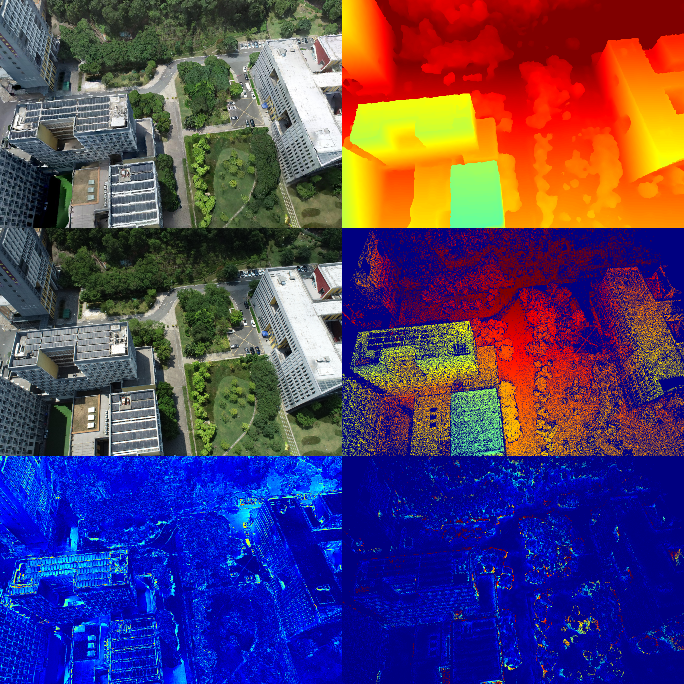

In [118]:
results_down = cv2.resize(cat_results, (cat_results.shape[1]//4, cat_results.shape[0]//4))
Image.fromarray((results_down).astype(np.uint8)[:,:,::-1])

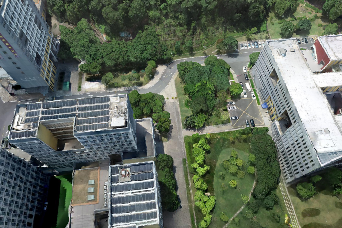

In [119]:
rgb_np_down = cv2.resize(rgb_np, (rgb_np.shape[1]//4, rgb_np.shape[0]//4))
Image.fromarray((rgb_np_down * 255).astype(np.uint8)[:,:,::-1])

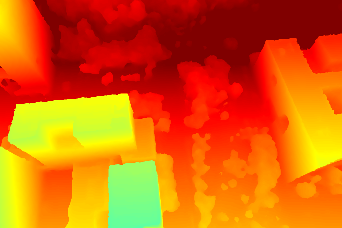

In [120]:
depth_color_down = cv2.resize(depth_color, (depth_color.shape[1]//4, depth_color.shape[0]//4))
Image.fromarray(depth_color_down[:,:,::-1].astype(np.uint8))


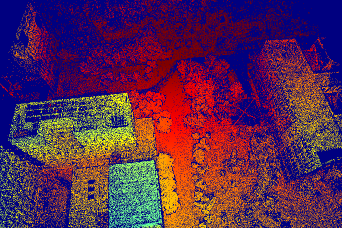

In [121]:
lidar_depth_color_down = cv2.resize(lidar_depth_color, (depth_color.shape[1]//4, depth_color.shape[0]//4))
Image.fromarray(lidar_depth_color_down.astype(np.uint8)[:,:,::-1])

In [122]:

#Image.fromarray(depth_diff_color[:, :, ::-1])